In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [39]:
sunspot_data = pd.read_csv("sunspot.csv")
tsi_data = pd.read_csv("tsi.csv")

In [40]:
merged_data = pd.merge(sunspot_data, tsi_data, on=["year", "month"], how="inner")
merged_data = merged_data.sort_values(by=["year", "month"]).reset_index(drop=True)

In [41]:
merged_data.head()

,ssn,year,month,tsi
0,210.9,1947,8,1363.841413
1,206.0,1947,9,1363.860329
2,206.3,1947,10,1363.898601
3,207.1,1947,11,1363.917975
4,205.7,1947,12,1363.884501


In [42]:
merged_data.tail()

,ssn,year,month,tsi
919,141.4,2024,3,1364.134573
920,144.5,2024,4,1364.138153
921,149.1,2024,5,1364.116684
922,152.7,2024,6,1364.114400
923,154.9,2024,7,1364.112282


In [18]:
WINDOW_SIZE = 72  # 5 years * 12 months
FORECAST_HORIZON = 1  # Forecasting one month ahead
TRAIN_SPLIT = 0.8

In [19]:
def create_sequences(data, window_size, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_horizon + 1):
        # Use both ssn and tsi as features
        X.append(data[i:(i + window_size), :])
        # Target is only ssn
        y.append(data[i + window_size + forecast_horizon - 1, 0])
    return np.array(X), np.array(y)

In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(merged_data[['ssn', 'tsi']].values)

In [21]:
X, y = create_sequences(data_scaled, WINDOW_SIZE, FORECAST_HORIZON)

In [22]:
train_size = int(len(X) * TRAIN_SPLIT)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [23]:
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (681, 72, 2)
Testing data shape: (171, 72, 2)


In [24]:
def build_model(input_shape):
    model = Sequential()
    
    # First LSTM layer with return sequences for stacking
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    
    # Second LSTM layer
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    
    # Third LSTM layer
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    
    # Output layer
    model.add(Dense(1))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    
    return model

In [25]:
model = build_model((X_train.shape[1], X_train.shape[2]))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 72, 100)        │        41,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 72, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 72, 50)         │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 72, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,651 (358.01 KB)

 Trainable params: 91,651 (358.01 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
checkpoint = ModelCheckpoint('best_single.keras', 
                             monitor='val_loss', 
                             save_best_only=True, 
                             mode='min', 
                             verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=10, 
                              restore_best_weights=True)

In [27]:
history = model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=32, 
                    validation_split=0.2, 
                    callbacks=[checkpoint, early_stopping],
                    verbose=1)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0883
Epoch 1: val_loss improved from inf to 0.00915, saving model to best_single.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0862 - val_loss: 0.0092
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0131
Epoch 2: val_loss improved from 0.00915 to 0.00325, saving model to best_single.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0130 - val_loss: 0.0032
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0085
Epoch 3: val_loss improved from 0.00325 to 0.00314, saving model to best_single.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0085 - val_loss: 0.0031
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0052
Epoch 4: val_loss did not improve from 0.00314
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0060
Epoch 5: val_loss did not improve from 0.00314
17/17 ━━━━━━━━━━━━━━━

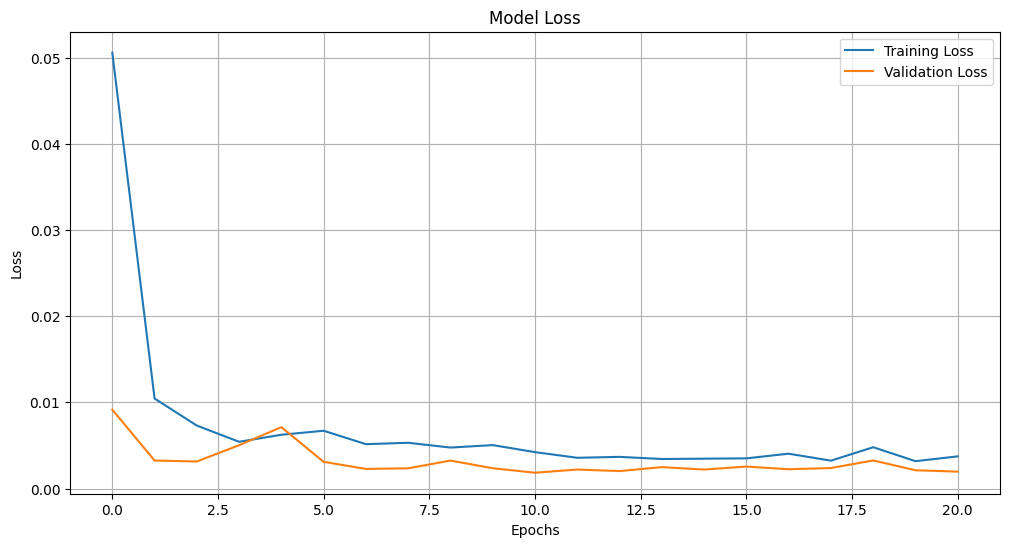

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
y_pred = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [30]:
# Create dummy array to match the shape for inverse_transform
y_test_inv = np.zeros((len(y_test), 2))
y_test_inv[:, 0] = y_test
y_test_inv = scaler.inverse_transform(y_test_inv)[:, 0]

# Inverse transform for predicted values
y_pred_inv = np.zeros((len(y_pred), 2))
y_pred_inv[:, 0] = y_pred.flatten()
y_pred_inv = scaler.inverse_transform(y_pred_inv)[:, 0]

In [31]:
mse = np.mean((y_test_inv - y_pred_inv) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test_inv - y_pred_inv))

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 372.19
RMSE: 19.29
MAE: 16.90


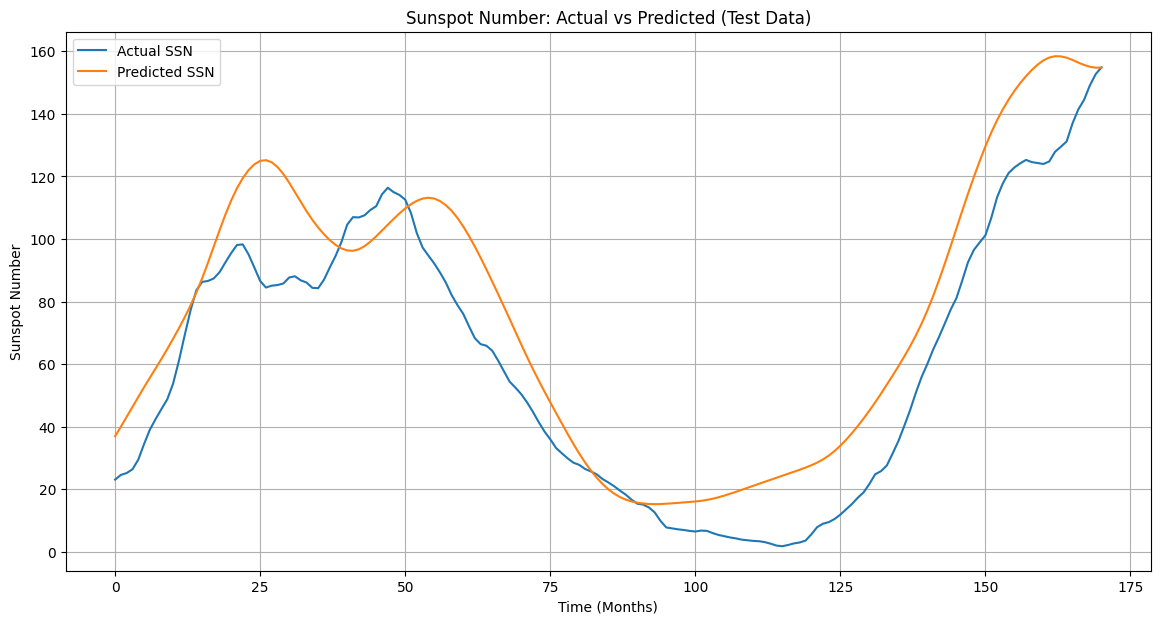

In [32]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_inv, label='Actual SSN')
plt.plot(y_pred_inv, label='Predicted SSN')
plt.title('Sunspot Number: Actual vs Predicted (Test Data)')
plt.xlabel('Time (Months)')
plt.ylabel('Sunspot Number')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# Calculate number of months from last data point (July 2024) to end of 2030
last_date = pd.Timestamp(year=2024, month=7, day=1)
end_date = pd.Timestamp(year=2030, month=12, day=31)
forecast_months = (end_date.year - last_date.year) * 12 + (end_date.month - last_date.month)
print(f"Forecasting {forecast_months} months into the future")

# Get the last window of data for forecasting
forecast_input = data_scaled[-WINDOW_SIZE:]
forecast_input = forecast_input.reshape(1, forecast_input.shape[0], forecast_input.shape[1])

Forecasting 77 months into the future


In [34]:
forecasted_values = []

for _ in range(forecast_months):
    # Make prediction for next month
    next_pred = model.predict(forecast_input)
    forecasted_values.append(next_pred[0, 0])
    
    # Create a new input with the predicted value
    # We need both features (ssn and tsi), but we can only predict ssn
    # For simplicity, we'll use the last tsi value
    new_input = np.zeros((1, 1, 2))
    new_input[0, 0, 0] = next_pred[0, 0]  # Predicted SSN
    new_input[0, 0, 1] = forecast_input[0, -1, 1]  # Last TSI value
    
    # Update forecast input by removing the first prediction and adding the new one
    forecast_input = np.concatenate([forecast_input[:, 1:, :], new_input], axis=1)

# Convert forecasted values to original scale
forecasted_array = np.zeros((len(forecasted_values), 2))
forecasted_array[:, 0] = forecasted_values
forecasted_ssn = scaler.inverse_transform(forecasted_array)[:, 0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

In [35]:
last_date = pd.Timestamp(year=2024, month=7, day=1)
future_dates = pd.date_range(start=pd.Timestamp(last_date) + pd.DateOffset(months=1), 
                             periods=forecast_months, 
                             freq='MS')

In [36]:
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecasted_SSN': forecasted_ssn
})

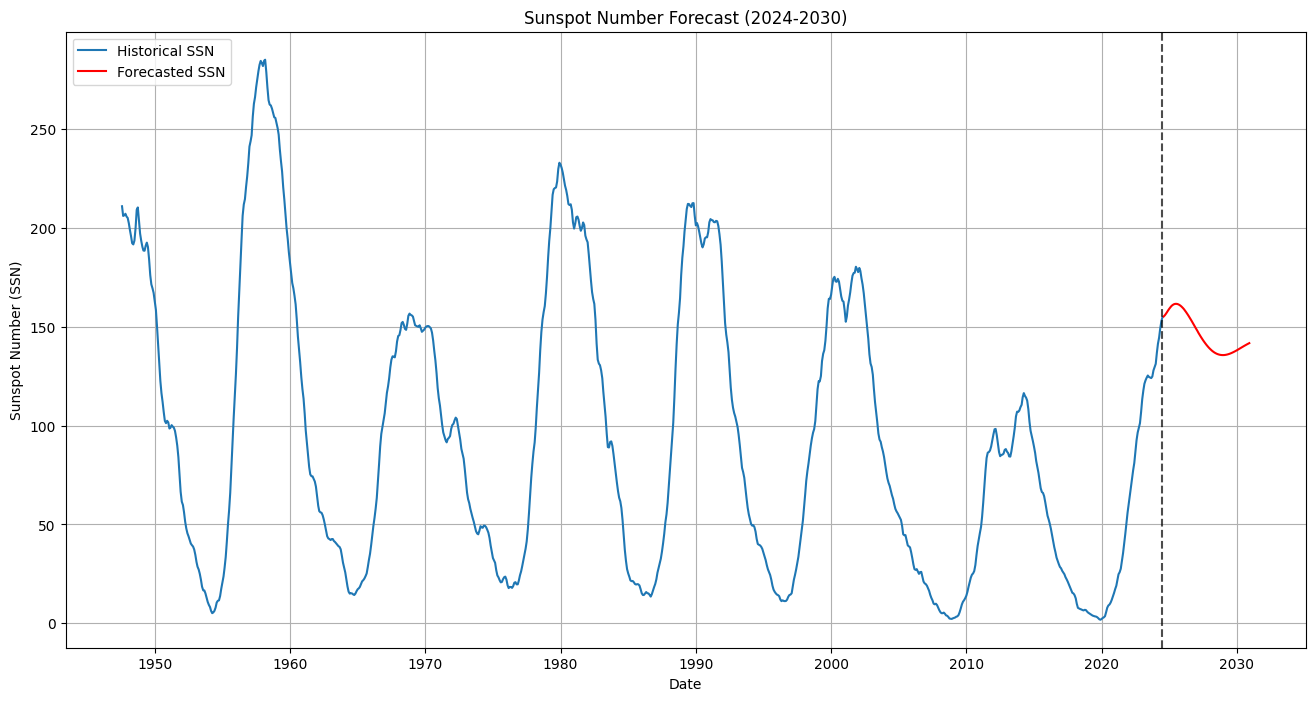

In [37]:
actual_dates = pd.to_datetime(merged_data['year'].astype(str) + '-' + merged_data['month'].astype(str) + '-01')
actual_ssn = merged_data['ssn'].values

plt.figure(figsize=(16, 8))
plt.plot(actual_dates, actual_ssn, label='Historical SSN')
plt.plot(future_dates, forecasted_ssn, label='Forecasted SSN', color='red')
plt.axvline(x=actual_dates.iloc[-1], color='black', linestyle='--', alpha=0.7)
plt.title('Sunspot Number Forecast (2024-2030)')
plt.xlabel('Date')
plt.ylabel('Sunspot Number (SSN)')
plt.legend()
plt.grid(True)
plt.show()

# 2 Outputs

Training data shape: (710, 36, 2)
Testing data shape: (178, 36, 2)
Target shape: (710, 2)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 36, 64)         │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 36, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,954 (148.26 KB)

 Trainable params: 37,954 (148.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1341
Epoch 1: val_loss improved from inf to 0.02646, saving model to best.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1227 - val_loss: 0.0265
Epoch 2/100
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0378
Epoch 2: val_loss improved from 0.02646 to 0.01447, saving model to best.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0372 - val_loss: 0.0145
Epoch 3/100
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0221
Epoch 3: val_loss improved from 0.01447 to 0.00683, saving model to best.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0218 - val_loss: 0.0068
Epoch 4/100
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0172
Epoch 4: val_loss did not improve from 0.00683
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0169 - val_loss: 0.0127
Epoch 5/100
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0146
Epoch 5: val_loss did not improve from 0.00683
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - 

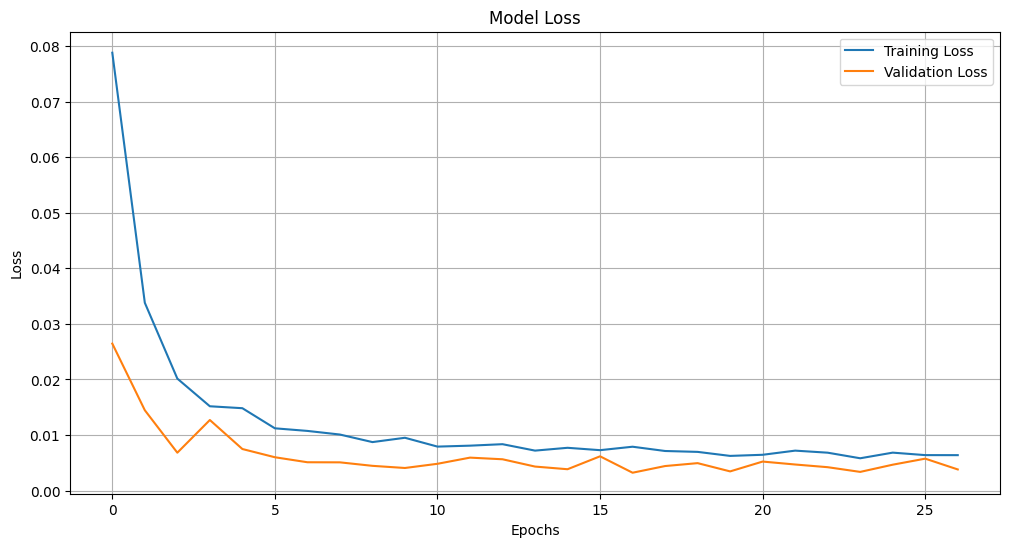

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SSN Metrics - MSE: 379.22, RMSE: 19.47, MAE: 17.19
TSI Metrics - MSE: 0.00857790, RMSE: 0.09261694, MAE: 0.07713369


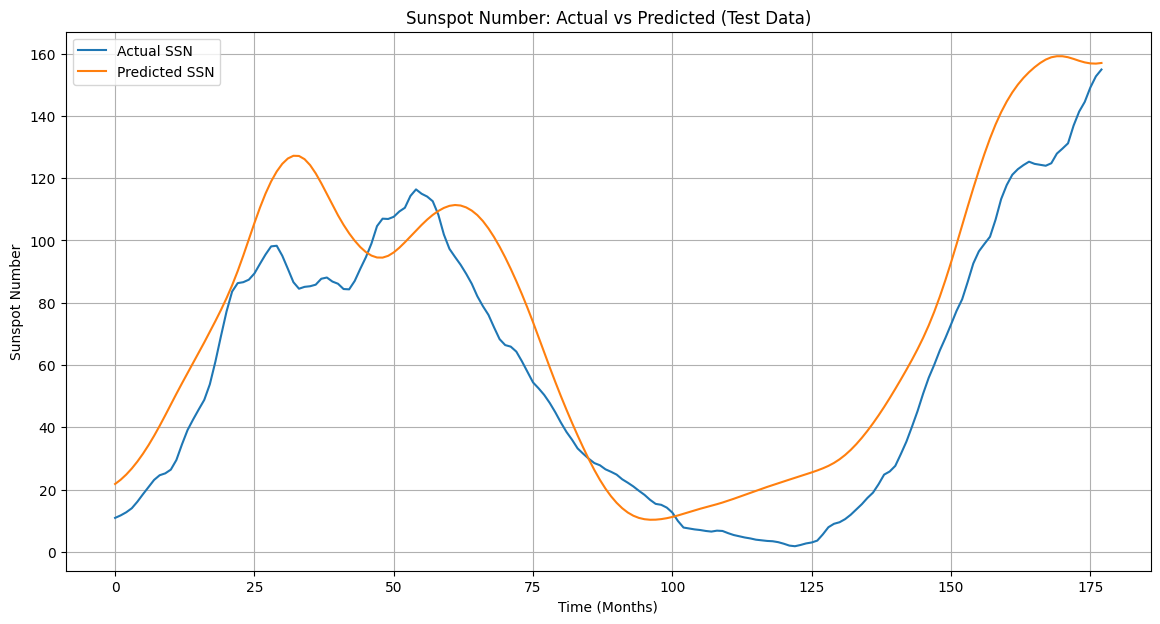

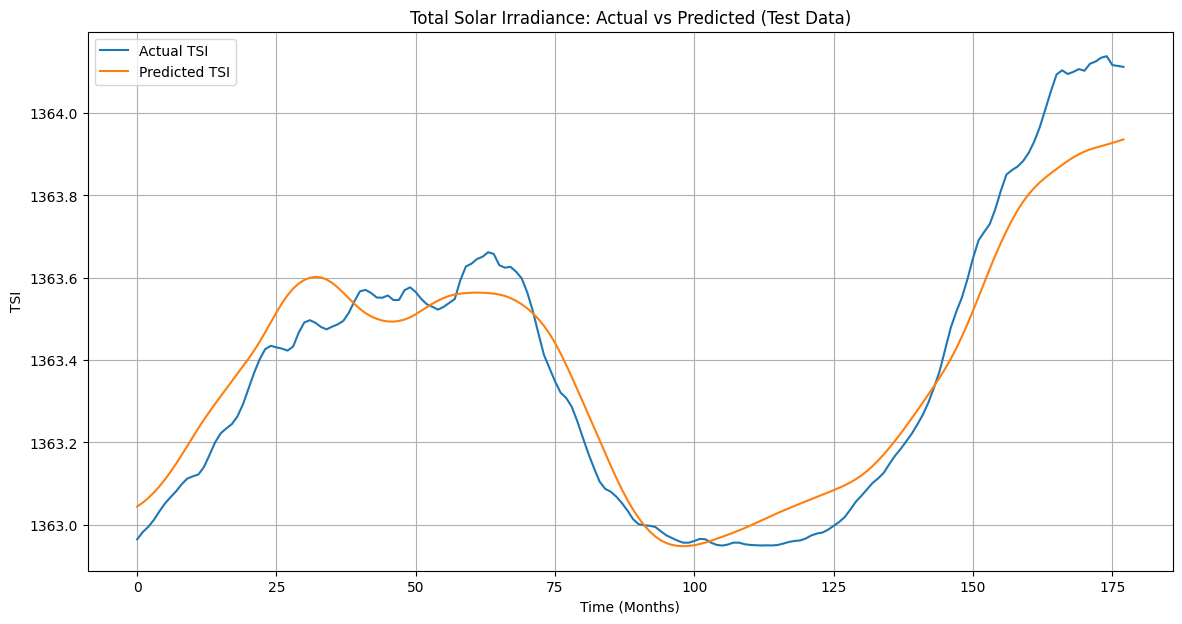

Forecasting 77 months into the future
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

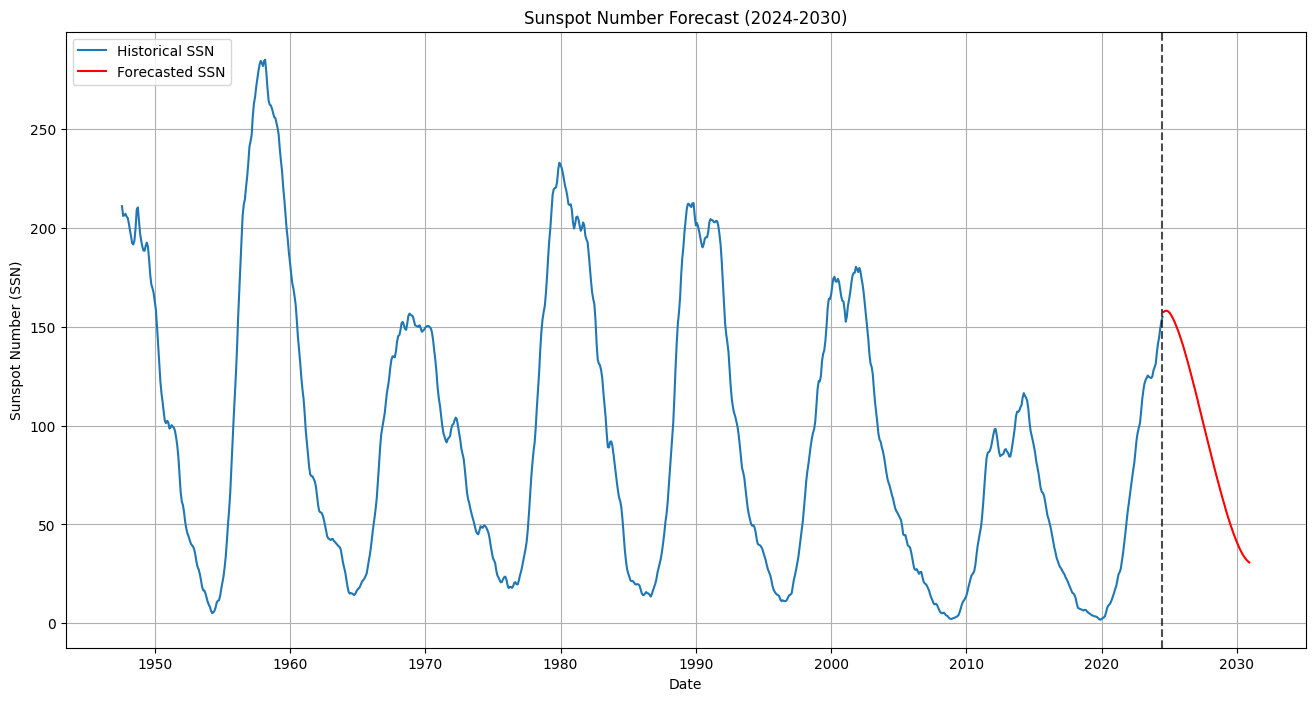

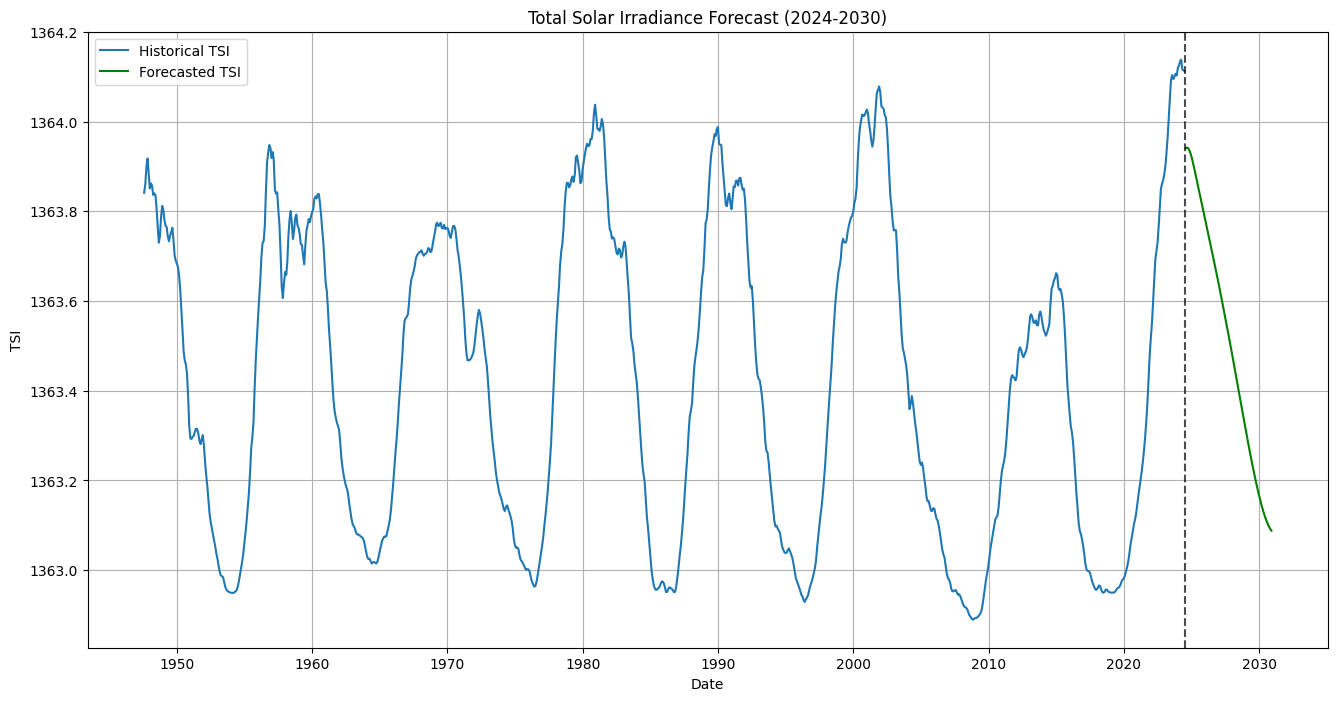

In [8]:
# Step 1: Data Preparation
# Define constants
WINDOW_SIZE = 36  # 5 years * 12 months
FORECAST_HORIZON = 1  # Forecasting one month ahead
TRAIN_SPLIT = 0.8  # 80% train, 20% test

# Create sequences function - modified to return both SSN and TSI as targets
def create_sequences(data, window_size, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_horizon + 1):
        # Use both ssn and tsi as features
        X.append(data[i:(i + window_size), :])
        # Target is now both SSN and TSI
        y.append(data[i + window_size + forecast_horizon - 1, :])
    return np.array(X), np.array(y)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(merged_data[['ssn', 'tsi']].values)

# Create sequences with both SSN and TSI as targets
X, y = create_sequences(data_scaled, WINDOW_SIZE, FORECAST_HORIZON)

# Split data into train and test sets
train_size = int(len(X) * TRAIN_SPLIT)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Target shape: {y_train.shape}")  # Should show 2 outputs

# Step 2: Build Stacked LSTM Model - modified to output 2 values
def build_model(input_shape, output_dim):
    model = Sequential()
    
    # First LSTM layer with return sequences for stacking
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    
    # Second LSTM layer
    model.add(LSTM(32, return_sequences=True))
    model.add(Dropout(0.2))
    
    # Third LSTM layer
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.2))
    
    # Output layer - now outputs 2 values (SSN and TSI)
    model.add(Dense(output_dim))
    
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    
    return model

# Build model with 2 output dimensions
model = build_model((X_train.shape[1], X_train.shape[2]), output_dim=2)
model.summary()

# Step 3: Train the model with checkpoints
# Create callbacks
checkpoint = ModelCheckpoint('best.keras', 
                             monitor='val_loss', 
                             save_best_only=True, 
                             mode='min', 
                             verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=10, 
                              restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=32, 
                    validation_split=0.2, 
                    callbacks=[checkpoint, early_stopping],
                    verbose=1)

# Step 4: Evaluate model
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Make predictions on test data
y_pred = model.predict(X_test)

# Inverse transform for actual values
y_test_inv = scaler.inverse_transform(y_test)

# Inverse transform for predicted values
y_pred_inv = scaler.inverse_transform(y_pred)

# Extract SSN values (first column)
y_test_ssn = y_test_inv[:, 0]
y_pred_ssn = y_pred_inv[:, 0]

# Extract TSI values (second column)
y_test_tsi = y_test_inv[:, 1]
y_pred_tsi = y_pred_inv[:, 1]

# Calculate metrics for SSN
mse_ssn = np.mean((y_test_ssn - y_pred_ssn) ** 2)
rmse_ssn = np.sqrt(mse_ssn)
mae_ssn = np.mean(np.abs(y_test_ssn - y_pred_ssn))

# Calculate metrics for TSI
mse_tsi = np.mean((y_test_tsi - y_pred_tsi) ** 2)
rmse_tsi = np.sqrt(mse_tsi)
mae_tsi = np.mean(np.abs(y_test_tsi - y_pred_tsi))

print(f"SSN Metrics - MSE: {mse_ssn:.2f}, RMSE: {rmse_ssn:.2f}, MAE: {mae_ssn:.2f}")
print(f"TSI Metrics - MSE: {mse_tsi:.8f}, RMSE: {rmse_tsi:.8f}, MAE: {mae_tsi:.8f}")

# Plot test predictions vs actual for SSN
plt.figure(figsize=(14, 7))
plt.plot(y_test_ssn, label='Actual SSN')
plt.plot(y_pred_ssn, label='Predicted SSN')
plt.title('Sunspot Number: Actual vs Predicted (Test Data)')
plt.xlabel('Time (Months)')
plt.ylabel('Sunspot Number')
plt.legend()
plt.grid(True)
plt.show()

# Plot test predictions vs actual for TSI
plt.figure(figsize=(14, 7))
plt.plot(y_test_tsi, label='Actual TSI')
plt.plot(y_pred_tsi, label='Predicted TSI')
plt.title('Total Solar Irradiance: Actual vs Predicted (Test Data)')
plt.xlabel('Time (Months)')
plt.ylabel('TSI')
plt.legend()
plt.grid(True)
plt.show()

# Step 5: Forecast into the future (until 2030)
# Calculate number of months from last data point (July 2024) to end of 2030
last_date = pd.Timestamp(year=2024, month=7, day=1)
end_date = pd.Timestamp(year=2030, month=12, day=31)
forecast_months = (end_date.year - last_date.year) * 12 + (end_date.month - last_date.month)
print(f"Forecasting {forecast_months} months into the future")

# Get the last window of data for forecasting
forecast_input = data_scaled[-WINDOW_SIZE:]
forecast_input = forecast_input.reshape(1, forecast_input.shape[0], forecast_input.shape[1])

# Initialize forecasted values arrays for both SSN and TSI
forecasted_values = []

# Recursive forecasting - now using both predicted SSN and TSI
for _ in range(forecast_months):
    # Make prediction for next month (returns both SSN and TSI)
    next_pred = model.predict(forecast_input)
    forecasted_values.append(next_pred[0])
    
    # Create a new input with the predicted values (both SSN and TSI)
    new_input = np.zeros((1, 1, 2))
    new_input[0, 0, 0] = next_pred[0, 0]  # Predicted SSN
    new_input[0, 0, 1] = next_pred[0, 1]  # Predicted TSI
    
    # Update forecast input by removing the first prediction and adding the new one
    forecast_input = np.concatenate([forecast_input[:, 1:, :], new_input], axis=1)

# Convert forecasted values to original scale
forecasted_array = np.array(forecasted_values)
forecasted_inv = scaler.inverse_transform(forecasted_array)
forecasted_ssn = forecasted_inv[:, 0]
forecasted_tsi = forecasted_inv[:, 1]

# Create date range for forecasting
last_date = pd.Timestamp(year=2024, month=7, day=1)
future_dates = pd.date_range(start=pd.Timestamp(last_date) + pd.DateOffset(months=1), 
                             periods=forecast_months, 
                             freq='MS')

# Create a dataframe with forecasted values
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecasted_SSN': forecasted_ssn,
    'Forecasted_TSI': forecasted_tsi
})

print(forecast_df.head())

# Plot historical and forecasted SSN
# Get actual historical data for plotting
actual_dates = pd.to_datetime(merged_data['year'].astype(str) + '-' + merged_data['month'].astype(str) + '-01')
actual_ssn = merged_data['ssn'].values
actual_tsi = merged_data['tsi'].values

# Plot SSN forecast
plt.figure(figsize=(16, 8))
plt.plot(actual_dates, actual_ssn, label='Historical SSN')
plt.plot(future_dates, forecasted_ssn, label='Forecasted SSN', color='red')
plt.axvline(x=actual_dates.iloc[-1], color='black', linestyle='--', alpha=0.7)
plt.title('Sunspot Number Forecast (2024-2030)')
plt.xlabel('Date')
plt.ylabel('Sunspot Number (SSN)')
plt.legend()
plt.grid(True)
plt.show()

# Plot TSI forecast
plt.figure(figsize=(16, 8))
plt.plot(actual_dates, actual_tsi, label='Historical TSI')
plt.plot(future_dates, forecasted_tsi, label='Forecasted TSI', color='green')
plt.axvline(x=actual_dates.iloc[-1], color='black', linestyle='--', alpha=0.7)
plt.title('Total Solar Irradiance Forecast (2024-2030)')
plt.xlabel('Date')
plt.ylabel('TSI')
plt.legend()
plt.grid(True)
plt.show()

# Uncertainty estimation

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.1309
Epoch 1: val_loss improved from inf to 0.02217, saving model to mc_dropout_best.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 0.1282 - val_loss: 0.0222
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0306
Epoch 2: val_loss improved from 0.02217 to 0.00987, saving model to mc_dropout_best.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0303 - val_loss: 0.0099
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0134
Epoch 3: val_loss did not improve from 0.00987
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0133 - val_loss: 0.0137
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0112
Epoch 4: val_loss improved from 0.00987 to 0.00940, saving model to mc_dropout_best.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.0112 - val_loss: 0.0094
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0083
Epoch 5: val_loss improved from 0.00940 to 0.00772,

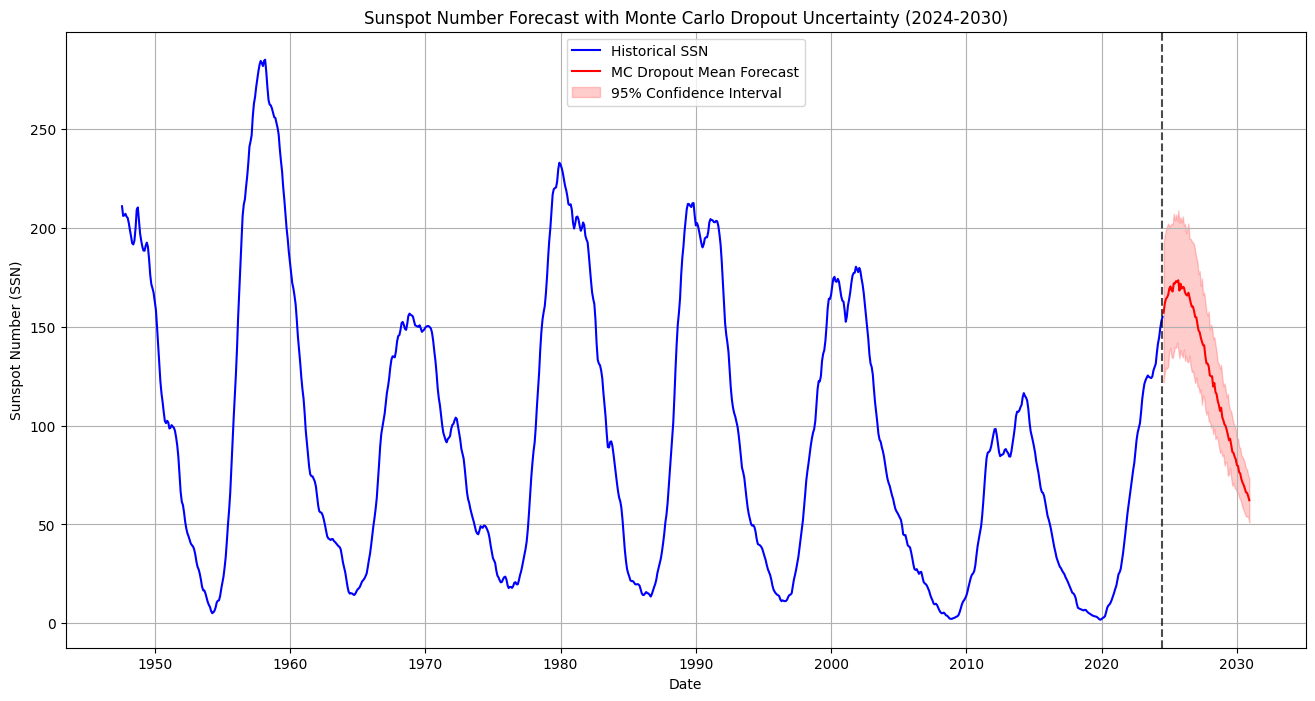

Epoch 1/100
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.7557 - q10_loss: 0.2510 - q50_loss: 0.2631 - q90_loss: 0.2416
Epoch 1: val_loss improved from inf to 0.20638, saving model to quantile_best.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.7275 - q10_loss: 0.2412 - q50_loss: 0.2532 - q90_loss: 0.2320 - val_loss: 0.2064 - val_q10_loss: 0.0698 - val_q50_loss: 0.0824 - val_q90_loss: 0.0639
Epoch 2/100
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2102 - q10_loss: 0.0719 - q50_loss: 0.0685 - q90_loss: 0.0698
Epoch 2: val_loss improved from 0.20638 to 0.11073, saving model to quantile_best.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.2082 - q10_loss: 0.0710 - q50_loss: 0.0678 - q90_loss: 0.0693 - val_loss: 0.1107 - val_q10_loss: 0.0350 - val_q50_loss: 0.0410 - val_q90_loss: 0.0358
Epoch 3/100
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1416 - q10_loss: 0.0493 - q50_loss: 0.0439 - q90_loss: 0.0484
Epoch 3: val_loss improved from 0.11073 to 0.08112, savi

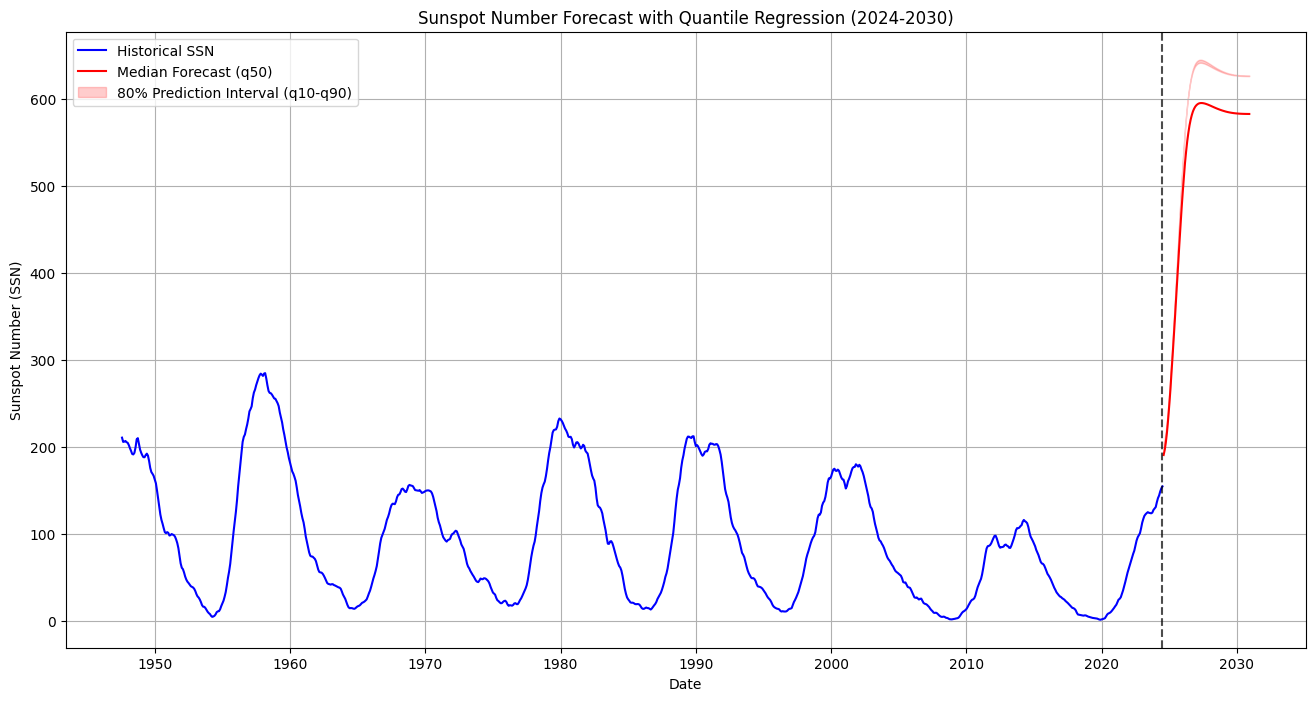

Training bootstrap model 1/10
Training bootstrap model 2/10
Training bootstrap model 3/10
Training bootstrap model 4/10
Training bootstrap model 5/10
Training bootstrap model 6/10
Training bootstrap model 7/10
Training bootstrap model 8/10
Training bootstrap model 9/10
Training bootstrap model 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━

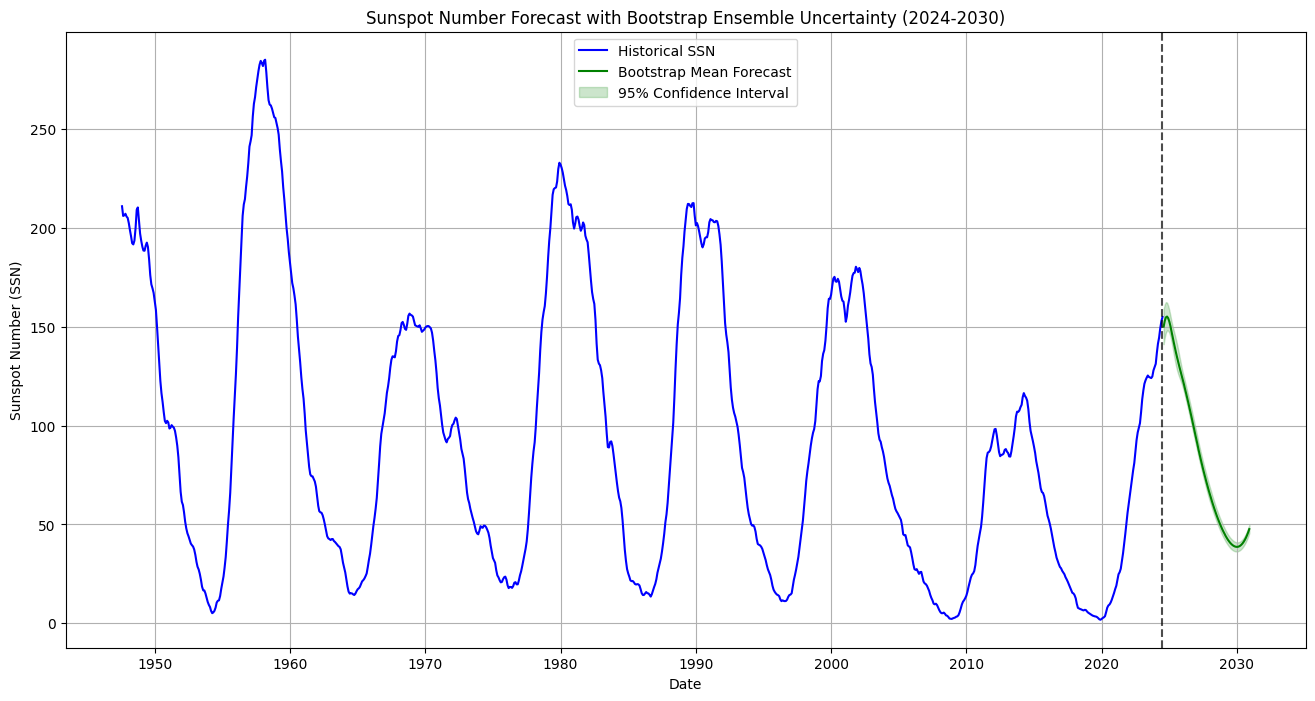

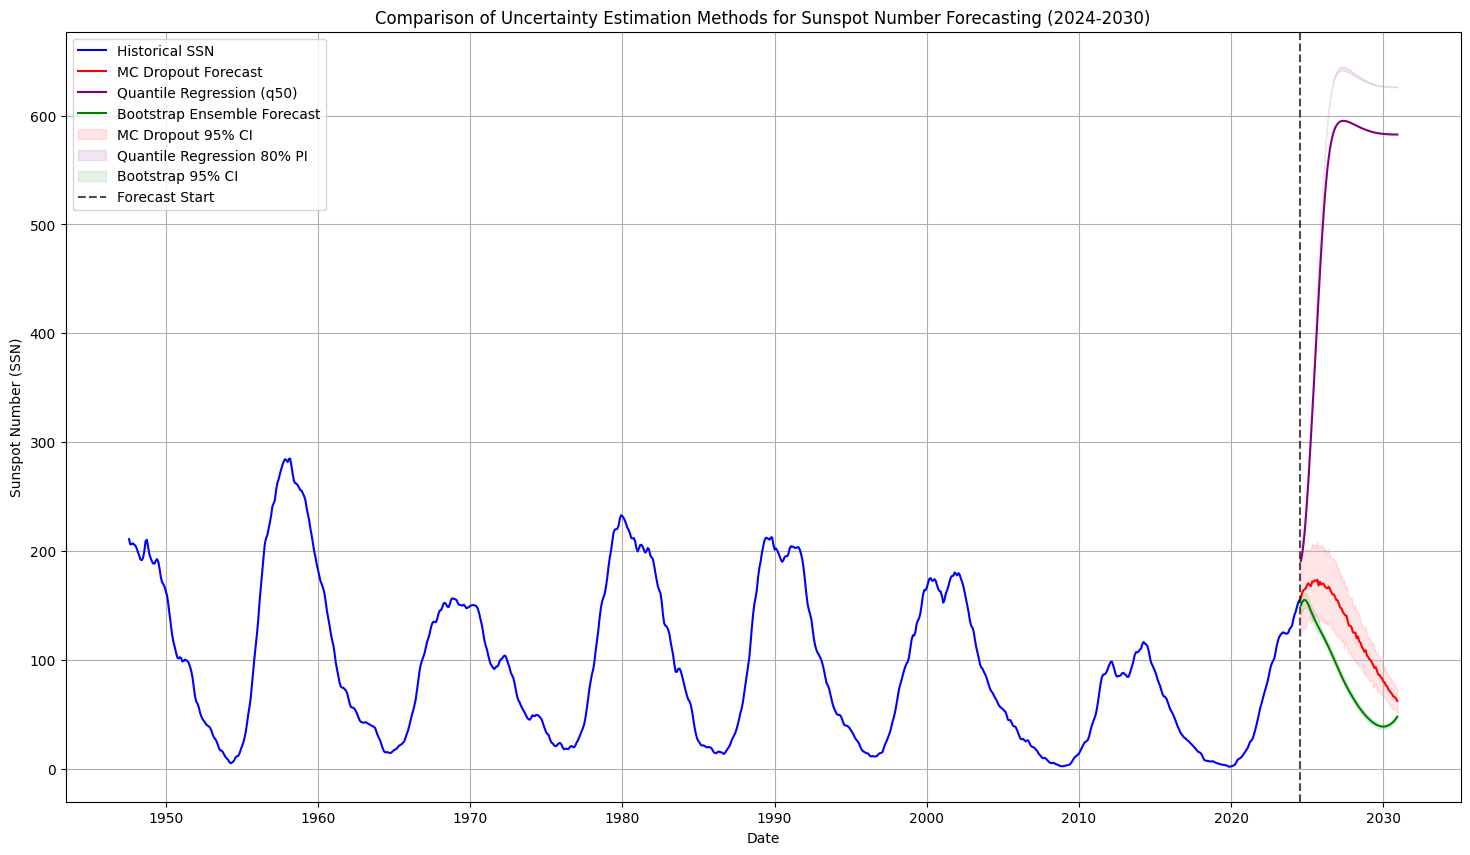

Uncertainty Estimation Performance Metrics on Test Data:
                Method       RMSE      PICP       MPIW
0  Monte Carlo Dropout  18.492960  0.456647  30.600098
1  Quantile Regression  22.795710  0.000000   3.545960
2   Bootstrap Ensemble  12.131218  0.190751   9.808912
Metrics saved to uncertainty_metrics.csv


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings('ignore')

# Assuming merged_data is already available from previous code

# Step 1: Data Preparation
# Define constants
WINDOW_SIZE = 60  # 5 years * 12 months
FORECAST_HORIZON = 1  # Forecasting one month ahead
TRAIN_SPLIT = 0.8  # 80% train, 20% test

# Create sequences function
def create_sequences(data, window_size, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_horizon + 1):
        X.append(data[i:(i + window_size), :])
        y.append(data[i + window_size + forecast_horizon - 1, :])
    return np.array(X), np.array(y)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(merged_data[['ssn', 'tsi']].values)

# Create sequences
X, y = create_sequences(data_scaled, WINDOW_SIZE, FORECAST_HORIZON)

# Split data into train and test sets
train_size = int(len(X) * TRAIN_SPLIT)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Calculate number of months to forecast
last_date = pd.Timestamp(year=2024, month=7, day=1)
end_date = pd.Timestamp(year=2030, month=12, day=31)
forecast_months = (end_date.year - last_date.year) * 12 + (end_date.month - last_date.month)

# Create date range for forecasting
future_dates = pd.date_range(start=pd.Timestamp(last_date) + pd.DateOffset(months=1), 
                             periods=forecast_months, 
                             freq='MS')

# Get actual historical data for plotting
actual_dates = pd.to_datetime(merged_data['year'].astype(str) + '-' + merged_data['month'].astype(str) + '-01')
actual_ssn = merged_data['ssn'].values
actual_tsi = merged_data['tsi'].values

# ---------------------------------------
# Method 1: Monte Carlo Dropout
# ---------------------------------------

class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

def build_mc_dropout_model(input_shape, output_dim):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(MCDropout(0.2))
    model.add(LSTM(50, return_sequences=True))
    model.add(MCDropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(MCDropout(0.2))
    model.add(Dense(output_dim))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Build and train MC Dropout model
mc_model = build_mc_dropout_model((X_train.shape[1], X_train.shape[2]), 2)

checkpoint = ModelCheckpoint('mc_dropout_best.keras', 
                             monitor='val_loss', 
                             save_best_only=True, 
                             mode='min', 
                             verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=10, 
                               restore_best_weights=True)

history_mc = mc_model.fit(X_train, y_train, 
                         epochs=100, 
                         batch_size=32, 
                         validation_split=0.2, 
                         callbacks=[checkpoint, early_stopping],
                         verbose=1)

# Monte Carlo inference function
def mc_predict(model, X, num_samples=100):
    preds = []
    for _ in range(num_samples):
        preds.append(model.predict(X))
    return np.array(preds)

# Get MC predictions on test data
mc_preds_test = mc_predict(mc_model, X_test, num_samples=100)

# Calculate mean and standard deviation
mc_mean_test = np.mean(mc_preds_test, axis=0)
mc_std_test = np.std(mc_preds_test, axis=0)

# Inverse transform for visualization
mc_mean_test_inv = scaler.inverse_transform(mc_mean_test)
mc_upper_test_inv = scaler.inverse_transform(mc_mean_test + 2 * mc_std_test)
mc_lower_test_inv = scaler.inverse_transform(mc_mean_test - 2 * mc_std_test)
y_test_inv = scaler.inverse_transform(y_test)

# Forecast future values with uncertainty
forecast_input = data_scaled[-WINDOW_SIZE:]
forecast_input = forecast_input.reshape(1, forecast_input.shape[0], forecast_input.shape[1])

mc_forecasts = []
for _ in range(forecast_months):
    # Generate multiple predictions
    mc_preds = mc_predict(mc_model, forecast_input, num_samples=100)
    mc_mean = np.mean(mc_preds, axis=0)[0]
    mc_std = np.std(mc_preds, axis=0)[0]
    
    # Store mean and standard deviation
    mc_forecasts.append((mc_mean, mc_std))
    
    # Update forecast input
    new_input = np.zeros((1, 1, 2))
    new_input[0, 0, 0] = mc_mean[0]
    new_input[0, 0, 1] = mc_mean[1]
    forecast_input = np.concatenate([forecast_input[:, 1:, :], new_input], axis=1)

# Extract means and standard deviations
mc_means = np.array([f[0] for f in mc_forecasts])
mc_stds = np.array([f[1] for f in mc_forecasts])

# Inverse transform for visualization
mc_means_inv = scaler.inverse_transform(mc_means)
mc_upper_inv = scaler.inverse_transform(mc_means + 2 * mc_stds)
mc_lower_inv = scaler.inverse_transform(mc_means - 2 * mc_stds)

# Plot MC Dropout results for SSN
plt.figure(figsize=(16, 8))
plt.plot(actual_dates, actual_ssn, label='Historical SSN', color='blue')
plt.plot(future_dates, mc_means_inv[:, 0], label='MC Dropout Mean Forecast', color='red')
plt.fill_between(future_dates, 
                 mc_lower_inv[:, 0], 
                 mc_upper_inv[:, 0], 
                 alpha=0.2, 
                 color='red', 
                 label='95% Confidence Interval')
plt.axvline(x=actual_dates.iloc[-1], color='black', linestyle='--', alpha=0.7)
plt.title('Sunspot Number Forecast with Monte Carlo Dropout Uncertainty (2024-2030)')
plt.xlabel('Date')
plt.ylabel('Sunspot Number (SSN)')
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------------------
# Method 2: Quantile Regression
# ---------------------------------------

def quantile_loss(q, y_true, y_pred):
    """
    Quantile loss function
    """
    error = y_true - y_pred
    return K.mean(K.maximum(q * error, (q - 1) * error), axis=-1)

def build_quantile_model(input_shape, output_dim, quantiles=[0.1, 0.5, 0.9]):
    inputs = Input(shape=input_shape)
    x = LSTM(100, return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    x = LSTM(50, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(50, return_sequences=False)(x)
    x = Dropout(0.2)(x)
    
    outputs = []
    for q in quantiles:
        output_q = Dense(output_dim, name=f'q{int(q*100)}')(x)
        outputs.append(output_q)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    losses = {f'q{int(q*100)}': lambda y_true, y_pred: quantile_loss(q, y_true, y_pred) for q in quantiles}
    model.compile(optimizer=Adam(learning_rate=0.001), loss=losses)
    
    return model

# Build and train quantile regression model
quantiles = [0.1, 0.5, 0.9]
quantile_model = build_quantile_model((X_train.shape[1], X_train.shape[2]), 2, quantiles)

checkpoint = ModelCheckpoint('quantile_best.keras', 
                             monitor='val_loss', 
                             save_best_only=True, 
                             mode='min', 
                             verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=10, 
                               restore_best_weights=True)

# Custom training loop for quantile regression
history_quantile = quantile_model.fit(
    X_train, 
    {f'q{int(q*100)}': y_train for q in quantiles},
    epochs=100, 
    batch_size=32, 
    validation_split=0.2, 
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

# Predict quantiles on test data
quantile_preds_test = quantile_model.predict(X_test)
q10_preds = quantile_preds_test[0]
q50_preds = quantile_preds_test[1]
q90_preds = quantile_preds_test[2]

# Inverse transform for visualization
q10_inv = scaler.inverse_transform(q10_preds)
q50_inv = scaler.inverse_transform(q50_preds)
q90_inv = scaler.inverse_transform(q90_preds)

# Forecast future values with quantile regression
forecast_input = data_scaled[-WINDOW_SIZE:]
forecast_input = forecast_input.reshape(1, forecast_input.shape[0], forecast_input.shape[1])

q10_forecasts = []
q50_forecasts = []
q90_forecasts = []

for _ in range(forecast_months):
    # Generate quantile predictions
    q_preds = quantile_model.predict(forecast_input)
    q10 = q_preds[0][0]
    q50 = q_preds[1][0]
    q90 = q_preds[2][0]
    
    # Store quantile predictions
    q10_forecasts.append(q10)
    q50_forecasts.append(q50)
    q90_forecasts.append(q90)
    
    # Update forecast input using median prediction
    new_input = np.zeros((1, 1, 2))
    new_input[0, 0, 0] = q50[0]
    new_input[0, 0, 1] = q50[1]
    forecast_input = np.concatenate([forecast_input[:, 1:, :], new_input], axis=1)

# Convert to arrays
q10_forecasts = np.array(q10_forecasts)
q50_forecasts = np.array(q50_forecasts)
q90_forecasts = np.array(q90_forecasts)

# Inverse transform for visualization
q10_forecasts_inv = scaler.inverse_transform(q10_forecasts)
q50_forecasts_inv = scaler.inverse_transform(q50_forecasts)
q90_forecasts_inv = scaler.inverse_transform(q90_forecasts)

# Plot Quantile Regression results for SSN
plt.figure(figsize=(16, 8))
plt.plot(actual_dates, actual_ssn, label='Historical SSN', color='blue')
plt.plot(future_dates, q50_forecasts_inv[:, 0], label='Median Forecast (q50)', color='red')
plt.fill_between(future_dates, 
                 q10_forecasts_inv[:, 0], 
                 q90_forecasts_inv[:, 0], 
                 alpha=0.2, 
                 color='red', 
                 label='80% Prediction Interval (q10-q90)')
plt.axvline(x=actual_dates.iloc[-1], color='black', linestyle='--', alpha=0.7)
plt.title('Sunspot Number Forecast with Quantile Regression (2024-2030)')
plt.xlabel('Date')
plt.ylabel('Sunspot Number (SSN)')
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------------------
# Method 3: Bootstrap Ensembles
# ---------------------------------------

def build_bootstrap_model(input_shape, output_dim):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(output_dim))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Train multiple bootstrap models
n_bootstrap = 10
bootstrap_models = []

for i in range(n_bootstrap):
    print(f"Training bootstrap model {i+1}/{n_bootstrap}")
    
    # Generate bootstrap sample
    indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
    X_boot = X_train[indices]
    y_boot = y_train[indices]
    
    # Build and train model
    boot_model = build_bootstrap_model((X_train.shape[1], X_train.shape[2]), 2)
    
    checkpoint = ModelCheckpoint(f'bootstrap_model_{i+1}.keras', 
                                 monitor='val_loss', 
                                 save_best_only=True, 
                                 mode='min', 
                                 verbose=0)
    
    early_stopping = EarlyStopping(monitor='val_loss', 
                                   patience=10, 
                                   restore_best_weights=True)
    
    boot_model.fit(X_boot, y_boot, 
                   epochs=50,  # Reduced epochs for faster training
                   batch_size=32, 
                   validation_split=0.2, 
                   callbacks=[checkpoint, early_stopping],
                   verbose=0)
    
    bootstrap_models.append(boot_model)

# Predictions on test data
# Continuing with Method 3: Bootstrap Ensembles

# Predictions on test data
bootstrap_preds_test = np.array([model.predict(X_test) for model in bootstrap_models])

# Calculate mean and standard deviation
bootstrap_mean_test = np.mean(bootstrap_preds_test, axis=0)
bootstrap_std_test = np.std(bootstrap_preds_test, axis=0)

# Inverse transform for visualization
bootstrap_mean_test_inv = scaler.inverse_transform(bootstrap_mean_test)
bootstrap_upper_test_inv = scaler.inverse_transform(bootstrap_mean_test + 2 * bootstrap_std_test)
bootstrap_lower_test_inv = scaler.inverse_transform(bootstrap_mean_test - 2 * bootstrap_std_test)

# Forecast future values with bootstrap ensembles
forecast_input = data_scaled[-WINDOW_SIZE:]
forecast_input = forecast_input.reshape(1, forecast_input.shape[0], forecast_input.shape[1])

bootstrap_forecasts = []

for _ in range(forecast_months):
    # Generate predictions from all bootstrap models
    boot_preds = np.array([model.predict(forecast_input)[0] for model in bootstrap_models])
    
    # Calculate mean and standard deviation
    boot_mean = np.mean(boot_preds, axis=0)
    boot_std = np.std(boot_preds, axis=0)
    
    # Store mean and standard deviation
    bootstrap_forecasts.append((boot_mean, boot_std))
    
    # Update forecast input using mean prediction
    new_input = np.zeros((1, 1, 2))
    new_input[0, 0, 0] = boot_mean[0]
    new_input[0, 0, 1] = boot_mean[1]
    forecast_input = np.concatenate([forecast_input[:, 1:, :], new_input], axis=1)

# Extract means and standard deviations
bootstrap_means = np.array([f[0] for f in bootstrap_forecasts])
bootstrap_stds = np.array([f[1] for f in bootstrap_forecasts])

# Inverse transform for visualization
bootstrap_means_inv = scaler.inverse_transform(bootstrap_means)
bootstrap_upper_inv = scaler.inverse_transform(bootstrap_means + 2 * bootstrap_stds)
bootstrap_lower_inv = scaler.inverse_transform(bootstrap_means - 2 * bootstrap_stds)

# Plot Bootstrap Ensemble results for SSN
plt.figure(figsize=(16, 8))
plt.plot(actual_dates, actual_ssn, label='Historical SSN', color='blue')
plt.plot(future_dates, bootstrap_means_inv[:, 0], label='Bootstrap Mean Forecast', color='green')
plt.fill_between(future_dates, 
                 bootstrap_lower_inv[:, 0], 
                 bootstrap_upper_inv[:, 0], 
                 alpha=0.2, 
                 color='green', 
                 label='95% Confidence Interval')
plt.axvline(x=actual_dates.iloc[-1], color='black', linestyle='--', alpha=0.7)
plt.title('Sunspot Number Forecast with Bootstrap Ensemble Uncertainty (2024-2030)')
plt.xlabel('Date')
plt.ylabel('Sunspot Number (SSN)')
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------------------
# Compare all three methods on a single plot
# ---------------------------------------

plt.figure(figsize=(18, 10))

# Plot historical data
plt.plot(actual_dates, actual_ssn, label='Historical SSN', color='blue')

# Plot forecast line for each method
plt.plot(future_dates, mc_means_inv[:, 0], label='MC Dropout Forecast', color='red', linestyle='-')
plt.plot(future_dates, q50_forecasts_inv[:, 0], label='Quantile Regression (q50)', color='purple', linestyle='-')
plt.plot(future_dates, bootstrap_means_inv[:, 0], label='Bootstrap Ensemble Forecast', color='green', linestyle='-')

# Plot confidence intervals with low opacity
plt.fill_between(future_dates, 
                 mc_lower_inv[:, 0], 
                 mc_upper_inv[:, 0], 
                 alpha=0.1, 
                 color='red', 
                 label='MC Dropout 95% CI')

plt.fill_between(future_dates, 
                 q10_forecasts_inv[:, 0], 
                 q90_forecasts_inv[:, 0], 
                 alpha=0.1, 
                 color='purple', 
                 label='Quantile Regression 80% PI')

plt.fill_between(future_dates, 
                 bootstrap_lower_inv[:, 0], 
                 bootstrap_upper_inv[:, 0], 
                 alpha=0.1, 
                 color='green', 
                 label='Bootstrap 95% CI')

plt.axvline(x=actual_dates.iloc[-1], color='black', linestyle='--', alpha=0.7, label='Forecast Start')
plt.title('Comparison of Uncertainty Estimation Methods for Sunspot Number Forecasting (2024-2030)')
plt.xlabel('Date')
plt.ylabel('Sunspot Number (SSN)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# ---------------------------------------
# Calculate metrics for each method on test data
# ---------------------------------------

# 1. Calculate RMSE for point predictions
def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# 2. Calculate PICP (Prediction Interval Coverage Probability)
def calculate_picp(y_true, y_lower, y_upper):
    """Calculate percentage of true values falling within the prediction interval"""
    hits = np.sum((y_true >= y_lower) & (y_true <= y_upper))
    return hits / len(y_true)

# 3. Calculate MPIW (Mean Prediction Interval Width)
def calculate_mpiw(y_lower, y_upper):
    """Calculate average width of prediction intervals"""
    return np.mean(y_upper - y_lower)

# Extract SSN values for metrics calculation
y_test_ssn = y_test_inv[:, 0]

# MC Dropout metrics
mc_mean_ssn = mc_mean_test_inv[:, 0]
mc_lower_ssn = mc_lower_test_inv[:, 0]
mc_upper_ssn = mc_upper_test_inv[:, 0]

# Quantile Regression metrics
q50_ssn = q50_inv[:, 0]
q10_ssn = q10_inv[:, 0]
q90_ssn = q90_inv[:, 0]

# Bootstrap metrics
bootstrap_mean_ssn = bootstrap_mean_test_inv[:, 0]
bootstrap_lower_ssn = bootstrap_lower_test_inv[:, 0]
bootstrap_upper_ssn = bootstrap_upper_test_inv[:, 0]

# Create metrics dataframe
metrics = {
    'Method': ['Monte Carlo Dropout', 'Quantile Regression', 'Bootstrap Ensemble'],
    'RMSE': [
        calculate_rmse(y_test_ssn, mc_mean_ssn),
        calculate_rmse(y_test_ssn, q50_ssn),
        calculate_rmse(y_test_ssn, bootstrap_mean_ssn)
    ],
    'PICP': [
        calculate_picp(y_test_ssn, mc_lower_ssn, mc_upper_ssn),
        calculate_picp(y_test_ssn, q10_ssn, q90_ssn),
        calculate_picp(y_test_ssn, bootstrap_lower_ssn, bootstrap_upper_ssn)
    ],
    'MPIW': [
        calculate_mpiw(mc_lower_ssn, mc_upper_ssn),
        calculate_mpiw(q10_ssn, q90_ssn),
        calculate_mpiw(bootstrap_lower_ssn, bootstrap_upper_ssn)
    ]
}

metrics_df = pd.DataFrame(metrics)
print("Uncertainty Estimation Performance Metrics on Test Data:")
print(metrics_df)

# Save metrics to CSV
metrics_df.to_csv('uncertainty_metrics.csv', index=False)
print("Metrics saved to uncertainty_metrics.csv")

# ---------------------------------------
# Create combined forecast CSV
# ---------------------------------------

# Create a dataframe with all forecasts and uncertainty estimates
forecast_combined = pd.DataFrame({
    'Date': future_dates,
    'MC_Dropout_Mean_SSN': mc_means_inv[:, 0],
    'MC_Dropout_Lower_SSN': mc_lower_inv[:, 0],
    'MC_Dropout_Upper_SSN': mc_upper_inv[:, 0],
    'Quantile_q50_SSN': q50_forecasts_inv[:, 0],
    'Quantile_q10_SSN': q10_forecasts_inv[:, 0],
    'Quantile_q90_SSN': q90_forecasts_inv[:, 0],
    'Bootstrap_Mean_SSN': bootstrap_means_inv[:, 0],
    'Bootstrap_Lower_SSN': bootstrap_lower_inv[:, 0],
    'Bootstrap_Upper_SSN': bootstrap_upper_inv[:, 0],
    'MC_Dropout_Mean_TSI': mc_means_inv[:, 1],
    'Quantile_q50_TSI': q50_forecasts_inv[:, 1],
    'Bootstrap_Mean_TSI': bootstrap_means_inv[:, 1]
})